(v4_announcement)=

# PyMC 4.0 Release Announcement
:::{post} Apr 4, 2022
:tags: release, aesara, jax
:category: news
:author: Thomas Wiecki

We, the PyMC core development team, are incredibly excited to announce the release of a major rewrite of PyMC3 (now called just PyMC): `4.0`. This marks the first major new version in over 10 years. Internally, we have already been using PyMC 4.0 almost exclusively for many months and found it to be very stable and better in every aspect. Every user should upgrade, as there are many exciting new updates that we will talk about in this and upcoming blog posts. 

## Full API compatibility for model building

To get the main question out of the way: Yes, you can just keep your existing PyMC modeling code without having to change anything (in most cases) and get all the improvements for free. The only thing most users will have to change is the import from `import pymc3 as pm` to `import pymc as pm`. For more information, see the [quick migration guide](https://www.pymc-labs.io/blog-posts/the-quickest-migration-guide-ever-from-pymc3-to-pymc-v40/). If you are using more advanced features of PyMC beyond the modeling API, you might have to change some things.

## It's now called PyMC instead of PyMC3
First, the biggest news: **PyMC3 has been renamed to PyMC. PyMC3 version 3.x will stay under the current name to not break production systems but future versions will use the PyMC name everywhere.** While there were a few reasons for this, the main one is that PyMC3 4.0 looks quite confusing.

## What about PyMC4?
If you don't know what PyMC4 is, you can just skip this section. In brief, it was an experiment we did using TensorFlow Probability as a backend which we gave up on. The motivation for abandoning this is described in our previous post ["The Future of PyMC3, or: Theano is Dead, Long Live Theano"](https://pymc-devs.medium.com/the-future-of-pymc3-or-theano-is-dead-long-live-theano-d8005f8a0e9b)

In general, you should refer to this new version as "PyMC 4.0".

## Theano → Aesara

Getting to know other tensor libraries like `TensorFlow` and `PyTorch` better made us realize how amazing and unique `Theano` really was. It has a mature and hackable code base and a simple graph representation that allows easy graph manipulations, something that's very useful for probabilistic programming languages. In addition, `TensorFlow` and `PyTorch` focus on a dynamic graph which is useful for some things, but for a probabilistic programming package, a static graph is actually much better, and `Theano` is the only library that provides this.

So, we went ahead and forked the `Theano` library and undertook a massive cleaning up of the code-base (this charge was led by [Brandon Willard](https://twitter.com/brandontwillard)), removing swaths of old and obscure code, and restructuring the entire library to be more developer friendly.

This rewrite motivated renaming the package to [`Aesara`](https://github.com/aesara-devs/aesara) (Theano's daughter in Greek mythology). Quickly, a new developer team focused around improving `aesara` independent of `PyMC`.

One major new feature are support for other computational backends, namely `JAX` and `numba`. The way this works is that `aesara` is best understood as a computational graph library that allows you to build a computational graph out of array-operations (additions, multiplications, dot-products, indexing, for-loops). From this graph representation, we can do various things:
* graph optimizations like `log(exp(x)) -> x`
* symbolic rewrites like `N(0, 1) + a` -> `N(a, 1)`
* compilation of that graph to various computational backends.

Previously, `theano` supported Python and C as computational backends. But with `aesara` it is now possible, and in fact quite easy, to add new computational backends. We have currently added a `JAX` backend that comes with GPU support (see [this blog post](https://martiningram.github.io/mcmc-comparison/) for some impressive speed-ups using GPUs for sampling). We're also in the process of adding a `numba` backend.

For more information on how `aesara` works, see [this blog post by Ricardo Vieira]().

## What's new in PyMC 4.0?

Alright, let's get to the good stuff. What makes PyMC 4.0 so awesome?

### New JAX backend for faster sampling

By far the most exciting new feature are the new computational backends and the associated speed-ups. 

As mentioned above, `aesara` provides a representation of the model logp graph in form of various `aesara` `Ops` (operators) which represent the computations to be be performed. For example `exp(x + y)` would be an `Add` `Op` with two input arguments `x` and `y`. The result of the `Add` `Op` is then inputted into an `exp` `Op`.

This computation graph doesn't say anything about how we actually *execute* this graph, however. Before, we would transpile this graph to C-code which would then get compiled, loaded into Python as a C-extension, and then executed. But now, we can just transpile this graph to `JAX` instead.

While this by itself is already pretty exciting, because `JAX` is capable of a whole bunch of low-level optimizations which lead to faster model evaluation, our samplers are still written in Python, so there is still some call-overhead. 

To get rid of this, we can link the `JAX` graph produced by `aesara` with a sampler also written in `JAX`. That way, the model logp evaluation *and* the sampler are one big JAX graph that gets optimized and executed without any Python call-overhead. We currently support a NUTS implementation provided by [`numpyro`](http://pyro.ai/numpyro/) as well as [`blackjax`](https://github.com/blackjax-devs/blackjax).

Early experiments and benchmarks show [impressive speed-ups](https://martiningram.github.io/mcmc-comparison/). Here is a small example of how much faster this is on a fairly small and simple model: the hierarchical linear regression of the famous Radon example.

In [1]:
# Standard imports
import numpy as np
import arviz as a
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
np.set_printoptions(2)

In order to do side-by-side comparisons, I installed both, the old `PyMC3` and `Theano` as well as the new `PyMC 4.0` and `Aesara` into this environment. You will only need the new packages of course.

In [2]:
# PyMC Imports
import pymc3 as pm3 # PyMC3 3.11
import pymc as pm4 # PyMC 4.0

# Aesara and Theano imports
import theano.tensor as tt # used by PyMC3 3.11
import theano
import aesara.tensor as at # used by PyMC 4.0
import aesara

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


Load in radon dataset and preprocess:

In [3]:
data = pd.read_csv("/Users/twiecki/personal/homepage/WhileMyMCMCGentlySamples/content/radon.csv")
#data = pd.read_csv(pm4.get_data("radon.csv"))
county_names = data.county.unique()

data["log_radon"] = data["log_radon"].astype(theano.config.floatX)

county_idx, counties = pd.factorize(data.county)
coords = {
    "county": counties,
    "obs_id": np.arange(len(county_idx)),
}

Next, let's define our model inside of a function. Note that we provide `pm`, our PyMC library, as an argument here. This is a bit unusual but allows us to create this model in `pymc3` or `pymc 4.0`, depending on which module we pass in. Here you can also see that most models that work in `pymc3` also work in `pymc 4.0` without any code change, you only need to change your imports.

In [30]:
def build_model(pm, **kwargs):
    with pm.Model(coords=coords) as hierarchical_model:
        mu_a = pm.Normal("mu_a", mu=0.0, sigma=10)
        sigma_a = pm.HalfNormal("sigma_a", 5.0)
        mu_b = pm.Normal("mu_b", mu=0.0, sigma=10)
        sigma_b = pm.HalfNormal("sigma_b", 5.0)
        a = pm.Normal("a", dims="county") * sigma_a + mu_a
        b = pm.Normal("b", dims="county") * sigma_b + mu_b
        eps = pm.HalfNormal("eps", 5.0)
        radon_est = a[county_idx] + b[county_idx] * data.floor.values
        radon_like = pm.Normal(
            "radon_like", mu=radon_est, sigma=eps, observed=data.log_radon, 
            dims="obs_id"
        )
        
    return hierarchical_model

Create and sample model in `pymc3`, nothing special:

In [5]:
%%time
model_pymc3 = build_model(pm3)
with model_pymc3:
    idata_pymc3 = pm3.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
There were 90 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7165232860911727, but should be close to 0.8. Try to increase the number of tuning steps.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7212171537898012, but should be close to 0.8. Try to increase the number of tuning steps.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


CPU times: user 2.9 s, sys: 423 ms, total: 3.32 s
Wall time: 16.5 s


Create and sample model in `pymc` 4.0, also nothing special (but note that `pm.sample()` now returns and `InferenceData` object by default):

In [6]:
%%time
model_pymc4 = build_model(pm4)
with model_pymc4:
    idata_pymc4 = pm4.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, mu_b, sigma_b, a, b, eps]


/Users/twiecki/miniforge3/envs/pymc4b5/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b5/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b5/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b5/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Incre

CPU times: user 4.3 s, sys: 356 ms, total: 4.65 s
Wall time: 16.2 s


Now, lets use a JAX sampler instead. Here we use the one provided by `numpyro`. These samplers live in a different submodule `sampling_jax` but the plan is to integrate them into `pymc.sample(backend="JAX")`.

In [7]:
import pymc.sampling_jax

/Users/twiecki/miniforge3/envs/pymc4b5/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "
/Users/twiecki/miniforge3/envs/pymc4b5/lib/python3.10/site-packages/aesara/link/jax/dispatch.py:87: UserWarning: JAX omnistaging couldn't be disabled: Disabling of omnistaging is no longer supported in JAX version 0.2.12 and higher: see https://github.com/google/jax/blob/main/design_notes/omnistaging.md.
  warnings.warn(f"JAX omnistaging couldn't be disabled: {e}")
/Users/twiecki/miniforge3/envs/pymc4b5/lib/python3.10/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


In [8]:
%%time
with model_pymc4:
    idata = pm4.sampling_jax.sample_numpyro_nuts(progress_bar=False)

/Users/twiecki/miniforge3/envs/pymc4b5/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Compiling...
Compilation time =  0:00:00.751909
Sampling...
Sampling time =  0:00:04.354319
Transforming variables...
Transformation time =  0:00:00.026623
CPU times: user 7.24 s, sys: 78.9 ms, total: 7.32 s
Wall time: 5.26 s


In [9]:
%%time
with model_pymc4:
    idata = pm4.sampling_jax.sample_blackjax_nuts()

Compiling...
Compilation time =  0:00:00.677075
Sampling...
Sampling time =  0:00:06.728095
Transforming variables...
Transformation time =  0:00:00.855364
CPU times: user 10.3 s, sys: 75.3 ms, total: 10.4 s
Wall time: 8.37 s


That's a speed-up of 3x -- for a single-line code change! And this is just running things on the CPU, we can just as easily run this on the GPU where we saw even more impressive speed-ups (especially as we scale the data).

Again, for a more proper benchmark that also compares this to Stan, see [this blog post](https://martiningram.github.io/mcmc-comparison/).

#### The Future: Samplers written in `aesara`

While this current approach is already quite exciting, we can take this one step further. The setup we showed above takes the model logp graph (represented in `aesara`) and compiles it to `JAX`. The resulting `JAX` function we can then call from a sampler written in directly in `JAX` (i.e. `numpyro` or `blackjax`).

While lightning fast, this is suboptimal for two reasons:
1. For new backends, like `numba`, we would need to rewrite the sampler also in `numba`.
2. While we get low-level optimizations from `JAX` on the logp+sampler JAX-graph, we do not get any high-level optimizations, which is what `aesara` is great at, because `aesara` does not see the sampler.

With [`aehmc`](https://www.github.com/aesara-devs/aehmc) and [`aemcmc`](https://www.github.com/aesara-devs/aemcmc) the `aesara` devs are developing a library of samplers *written in `aesara`*. That way, our model logp, consisting out of `aesara` `Ops` can then be combined with the sampler logic, now also consisting out of `aesara` `Ops`, and form one big `aesara` graph.

On that big graph containing model *and* sampler, `aesara` can the do high-level optimizations to get a more efficient graph representation. In a next step it can then compile it to whatever backend we want: `JAX`, `numba`, `C`, or whatever other backend we add in the future.

If you think this is interesting, definitely check out these packages and consider contributing, this is where the next round of innovation will come from!

## Better integration into `aesara`

The next feature we are excited about is a better integration of `PyMC` into `aesara`.

In `PyMC3 3.x`, the random variables (RVs) created by e.g. calling `x = pm.Normal('x')` were not truly `theano` `Ops` so they did not integrate as nicely with the rest of `theano`. This created a lot of issues, limitations, and complexities in the library.

`Aesara` now provides a proper `RandomVariable` Op which perfectly integrates with the rest of the other `Ops`. 

This is a major change in `4.0` and lead to huge swaths of brittle code in PyMC3 get removed or greatly simplified. In many ways, this change is much more exciting than the different computational backends, but the effects are not quite as visible to the user.

There are a few cases, however, where you can see the benefits.

### Faster posterior predictive sampling

In [11]:
%%time

with model_pymc3:
    pm3.sample_posterior_predictive(idata_pymc3)

CPU times: user 1min 30s, sys: 3.6 s, total: 1min 33s
Wall time: 1min 34s


In [12]:
%%time

with model_pymc4:
    pm4.sample_posterior_predictive(idata_pymc4)

CPU times: user 3.92 s, sys: 12.7 ms, total: 3.93 s
Wall time: 3.94 s


On this model, we get a speed-up of 22x!

The reason for this is that predictive sampling is now happening as part of the `aesara` graph. Before, we were walking through the random variables in Python which was not only slow, but also very error-prone, so a lot of dev time was spent fixing bugs and rewriting this complicated piece of code. In `PyMC` 4.0, all that complexity is gone.

## Work with RVs just like with Tensors

In PyMC3, RVs as returned by e.g. `pm.Normal("x")` behaved somewhat like a Tensor variable, but not *quite*. In PyMC 4.0, RVs are first-class Tensor variables that can be operated on much more freely.

In [13]:
with pm3.Model():
    x3 = pm3.Normal("x")
    
with pm4.Model():
    x4 = pm4.Normal("x")

In [14]:
type(x3)

pymc3.model.FreeRV

In [15]:
type(x4)

aesara.tensor.var.TensorVariable

Through the power of [`aeppl`](https://github.com/aesara-devs/aeppl) (a new low-level library that provides core building blocks for probabilistic programming languages on top of `aesara`), PyMC 4.0 allows you to do even more operations directly on the RV.

For example, we can just call `aesara.tensor.clip()` on a RV to truncate certain parameter ranges. Separately, calling `.eval()` on a RV samples a random draw from the RV, this is also new in PyMC 4.0 and makes things more consistent and allows easy interactions with RVs. 

In [16]:
at.clip(x4, 0, np.inf).eval()

array(0.)

<AxesSubplot:ylabel='Count'>

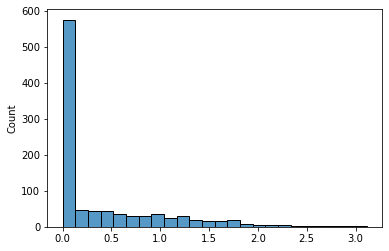

In [17]:
trunc_norm = [at.clip(x4, 0, np.inf).eval() for _ in range(1000)]
sns.histplot(np.asarray(trunc_norm))

As you can see, negative values are clipped to be 0. And you can use this, just like any other transform, directly in your model.

But there are other things you can do as well, like `stack()` RVs, and then index into them with a binary RV.

In [27]:
with pm4.Model():
    x = pm4.Uniform("x", lower=-1, upper=0) # only negtive
    y = pm4.Uniform("y", lower=0, upper=1) # only positive
    xy = at.stack([x, y]) # combined
    index = pm4.Bernoulli("index", p=0.5) # index 0 or 1
    
    indexed_RV = xy[index] # binary index into stacked variable

for _ in range(5):
    print("Sampled value = {:.2f}".format(indexed_RV.eval()))

Sampled value = -0.42
Sampled value = 0.80
Sampled value = -0.66
Sampled value = 0.01
Sampled value = 0.42


As you can see, depending on whether `index` is `0` or `1` we either sample from the negative or positive uniform. This also supports fancy indexing, so you can manually create complicated mixture distribution using a `Categorical` like this:

In [28]:
with pm4.Model():
    x = pm4.Uniform("x", lower=-1, upper=0)
    y = pm4.Uniform("y", lower=0, upper=1)
    z = pm4.Uniform("z", lower=1, upper=2)
    xyz = at.stack([x, y, z])
    index = pm4.Categorical("index", [.3, .3], shape=3)
    
    index_RV = xyz[index]

for _ in range(5):
    print("Sampled value = {}".format(index_RV.eval()))

Sampled value = [ 0.68 -0.52 -0.52]
Sampled value = [0.04 0.04 0.04]
Sampled value = [-0.59 -0.59  0.26]
Sampled value = [ 0.24  0.24 -0.56]
Sampled value = [ 0.59 -0.41 -0.41]


/Users/twiecki/miniforge3/envs/pymc4b5/lib/python3.10/site-packages/pymc/distributions/discrete.py:1281: UserWarning: `p` parameters sum to [0.6], instead of 1.0. They will be automatically rescaled. You can rescale them directly to get rid of this warning.
  warnings.warn(


## Better (and Dynamic) Shape Support

Another big improvement in `PyMC` 4.0 is in how shapes are handled internally. Before, there was also a bunch of complicated and brittle Python code to handle shapes. Internally, we had a joke where we counted how many days had passed until we had discovered a new shape bug. But no more! Now, all shape handling is completely offloaded to `aesara` which handles this properly. As a sid-effect, this better shape support also allows dynamic RV shapes, where the shape depends on another RV:

In [20]:
with pm4.Model() as m:
    x = pm4.Poisson('x', 2)
    z = pm4.Normal('z', shape=x)
    
for _ in range(5):
    print("Value of z = {}".format(z.eval()))

Value of z = []
Value of z = [0.14]
Value of z = [ 1.02  0.39 -0.77 -0.6 ]
Value of z = [1.05]
Value of z = [ 1.2   1.25 -1.8   0.91  0.12 -0.28]


As you can see, the shape of `z` changes with each draw according to the integer sampled by `x`.

Note, however, that this does not yet work for posterior inference (i.e. sampling). The reason is that the trace backend (`arviz.InferenceData`) as well as samplers in this case also must support changing dimensionality (like reversible-jump MCMC). There are plans to add this.

## Better NUTS initialization

We have also fixed an issue with the default NUTS warm-up which sometimes lead to the sampler getting stuck for a while. While fixing this issue, [Adrian Seyboldt](https://twitter.com/aseyboldt) also came up with a new initialization method that uses the gradients to estimate a better mass-matrix. You can use this (still experimental) feature by calling `pm.sample(init="jitter+adapt_diag_grad")`.

Let's try this on the hierarchical regression model from above:

In [31]:
with model_pymc4:
    idata_pymc4_grad = pm4.sample(init="jitter+adapt_diag_grad")

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag_grad...
INFO:pymc:Initializing NUTS using jitter+adapt_diag_grad...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, mu_b, sigma_b, a, b, eps]
INFO:pymc:NUTS: [mu_a, sigma_a, mu_b, sigma_b, a, b, eps]


/Users/twiecki/miniforge3/envs/pymc4b5/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b5/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b5/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b5/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


The first thing to observe as that we did not get any divergences this time. Comparing the effective sample size of the default and grad-based initialization, we can also see that it leads to much better sampling for certain parameters:

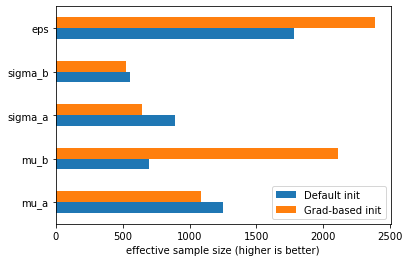

In [33]:
import arviz as az

pd.DataFrame({"Default init": az.summary(idata_pymc4, var_names=["~a", "~b"])["ess_bulk"],
              "Grad-based init": az.summary(idata_pymc4_grad, var_names=["~a", "~b"])["ess_bulk"]}).plot.barh()
plt.xlabel("effective sample size (higher is better)");

## A Look Towards the Future

As mentioned in the beginning, `aesara` is a unique library in the PyData ecosystem as it is the only one that provides a static, mutable computation graph. Having direct access to this computation graph allows for many interesting features. Above we already mentioned simplfications like turning `exp(log(x))` into `x`, and `aesara` already implements many of these. While we don't have proper benchmarks, we noticed major speed-ups of porting models from PyMC3 to 4.0, even without the JAX backend.

But these graph rewrites can become much more sophisticated. For example, [a beta prior on a binomial likelihood can be replaced with its analytical solution directly by exploiting conjugacy](https://github.com/aesara-devs/aemcmc/pull/29). 

Or a hierarchical model written in a centered parameterization can automatically be converted to its [non-centered analog](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/) which often samples much more efficiently. These model reparameterizations can make a huge difference in how well a model samples. Unforutnately, these reparameterizations still require intimate knowledge of the math and a deep understanding of the posterior geometry, nothing a casual PyMC user would be familiar with. So with these graph rewrites we will be able to automatically reparameterize a PyMC model for you and find the configuration that samples most efficiently.

**In sum, we believe PyMC 4.0 is the best version yet and pushes the state of the art in probabilistic programming. But it's also stepping stone to many more innovations to come. Thanks for being a part of it.**

## Accolades

While many people contributed to this effort, we would like to highlight the outstanding contributions of [Brandon Willard](https://brandonwillard.github.io), [Ricardo Vieira](https://github.com/ricardoV94), and [Kaustubh Chaudhari](https://github.com/kc611) who lead this gigantic effort.